# Cluster Modeling

In [215]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
from datetime import datetime
import datetime as dt  # Used to manage dates
import warnings                   # To ignore the warnings warnings.filterwarnings("ignore")
from dateutil.parser import parse 
import pymysql # Import MySql 
import warnings                   # To ignore the warnings warnings.filterwarnings("ignore")
import requests

from scipy import signal
from scipy.special import inv_boxcox
from scipy import stats as stats # Used for calculating z-values

import numpy as np # Used for calculating statistics on data
import random
import math
from math import sqrt, log, exp
import itertools

import pandas as pd # Used for loading-in and viewing data


import matplotlib.pyplot as plt # Used for creating graphics
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.pylab import rcParams 
from pylab import *
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import pylab as pl

import statsmodels.api as sm

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

import plotly.offline as py
from plotly import graph_objs as go
from plotly import figure_factory as ff
import plotly.express as px
from plotly.subplots import make_subplots




%matplotlib inline
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )

pd.plotting.register_matplotlib_converters()
pd.options.display.float_format = '{:.4f}'.format
rcParams.update({'figure.autolayout': True, 'figure.figsize':(12,8),'axes.titlesize':14})

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# to make this notebook's output identical at every run
np.random.seed(42)

# Functions Definitions

In [216]:
def read_data(file_name, index):
    df = pd.read_csv(file_name, sep=',', index_col=index, header='infer', float_precision=2 )
    return df

def save_data(df, file_name):
    # Write data to CSV File
    df.to_csv(path_or_buf=file_name, sep=',',index=False, encoding='utf-8')
    return

def update_df(df_household, df, column):
    df_household[column] = df[column]
    return df_household

def road_side_usage(calls):
    if calls > 0: return 1
    elif calls == 0: return 0
    else: return np.nan

def fill_with_zeros(df_household, fields):
    for i in fields:
        df_household[i].fillna(value=0, inplace=True)
    return df_household

def join_data_from_models(df_household, fields):
    # Create feature Cancel = 1 - member cancelled, if 0 active member
    df_household['aaa_cancel'] = 1
    df_household['aaa_cancel']=np.where(df_household['member_status']== 'ACTIVE', 0, 
                                        df_household['aaa_cancel'])
    df_household['aaa_cancel']=np.where(df_household['member_status']== 'PENDING', 0, 
                                        df_household['aaa_cancel'])
    df_household['aaa_cancel']=np.where(df_household['member_status']== 'CANCELLED', 1, 
                                        df_household['aaa_cancel'])
    # Create roadside usage
    df_household['use_road_side'] = df_household['total_calls'].apply(lambda x:road_side_usage(x))

    df_household.consumer_score = np.where(df_household.consumer_score!= np.nan, 1/df_household.consumer_score, 
                                           df_household.consumer_score)

    df_household.consumer_score = np.where(~(df_household.consumer_score > 0), df_household.consumer_score.mean(), 
                                           df_household.consumer_score)

    df_household.consumer_score = np.where(df_household.consumer_score== np.nan, df_household.consumer_score.mean(), 
                                           df_household.consumer_score)

    # Join results to main dataframe
    df_household = update_df(df_household, df_auto_insurance, 'yes_auto_insurance')
    df_household = update_df(df_household, df_cancel, 'will_cancel_prob')
    df_household = update_df(df_household, df_credit_card, 'yes_credit_card')
    df_household = update_df(df_household, df_deposit,'yes_deposit')
    df_household = update_df(df_household, df_home_equity, 'yes_home_equity')
    df_household = update_df(df_household, df_id_theft, 'yes_id_theft')
    df_household = update_df(df_household, df_mortgage, 'yes_mortgage')
    df_household = update_df(df_household, df_roadside, 'yes_roadside')
    df_household = update_df(df_household, df_travel, 'yes_travel')
    df_household = update_df(df_household, df_costs, 'estimated_cost')
    df_household['aaa_mean_age'] = np.round(df_household['aaa_mean_age'],0)
    df_household['aaa_mean_child'] = np.round(df_household['aaa_mean_child'],0)
    df_household = fill_with_zeros(df_household,fields)
    # Remove members with status CANCELLED
    df_household = df_household[df_household.member_status!='CANCELLED']
    return df_household

# Load Data outcomes from models

In [217]:
# Load House hold Data 
df_household = read_data('household_view.csv', 'membership_id')
# Load outcome of auto insurance model
df_auto_insurance = read_data('auto_reduced_feature_outcome.csv', 'membership_id')
# Load outcome of customer cancel model
df_cancel = read_data('cancel_reduced_feature_outcome.csv', 'membership_id')
# Load outcome of credit card model
df_credit_card = read_data('credit_reduced_feature_outcome.csv', 'membership_id')
# Load outcome of deposit model
df_deposit = read_data('deposit_reduced_feature_outcome.csv', 'membership_id')
# Load outcome of home equity model
df_home_equity = read_data('hequity_reduced_feature_outcome.csv', 'membership_id')
# Load outcome of ID Theft model
df_id_theft = read_data('idtheft_reduced_feature_outcome.csv', 'membership_id')
# Load outcome of Mortgage and Financial Services model
df_mortgage = read_data('mortgage_reduced_feature_outcome.csv', 'membership_id')
# Load outcome of Roadside model
df_roadside = read_data('rds_reduced_feature_outcome.csv', 'membership_id')
# Load outcome of Cost Prediction model
df_costs = read_data('totc_no_gap_reduced_feature_outcome.csv', 'membership_id')
# Load outcome of Cost Prediction model
df_travel = read_data('travel_reduced_feature_outcome.csv', 'membership_id')

# Join results to main dataframe

In [218]:
fields = ['yes_auto_insurance','will_cancel_prob', 'yes_credit_card', 'yes_deposit',
          'yes_home_equity', 'yes_id_theft', 'yes_mortgage', 'yes_roadside', 'yes_travel',
          'estimated_cost', 'aaa_mean_age', 'aaa_mean_child', 
         ]
df_household = join_data_from_models(df_household, fields)

In [219]:
df_household.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2937 entries, 153 to 543695
Data columns (total 97 columns):
household_key                        2937 non-null int64
income                               2937 non-null object
member_status                        2937 non-null object
state_grouped                        2937 non-null object
credit_ranges                        2937 non-null object
cancel_reason                        2937 non-null object
renew_method                         2937 non-null object
plus_indicator_description           2937 non-null object
zip                                  2937 non-null int64
sc_vehicle_manufacturer_name         2937 non-null object
sc_vehicle_model_name                2937 non-null object
race                                 2937 non-null object
home_owner                           2937 non-null object
education                            2937 non-null object
dwelling_type                        2937 non-null object
gender               

# Cluster KMeans Model

In [220]:
# Verify is there is no nulls
df_household[df_household.isnull().any(axis=1)].head(5)

,household_key,income,member_status,state_grouped,credit_ranges,cancel_reason,renew_method,plus_indicator_description,zip,sc_vehicle_manufacturer_name,sc_vehicle_model_name,race,home_owner,education,dwelling_type,gender,occupation_code,occupation_group,occupant_type,mosaic_household,mosaic_global_household,kcl_b_ind_mosaicsgrouping,generation,tenure,aaa_no_tenure,aaa_member_tenure_years,aaa_mean_age,length_of_residence,aaa_mortgage,aaa_credit_card,aaa_deposit,aaa_home_equity,aaa_financial_service,aaa_auto_insurance,aaa_id_theft,aaa_motorcycle_indicator,aaa_travel,aaa_mean_child,aaa_mean_total_cost,aaa_no_race,aaa_no_home_owner,aaa_no_education,aaa_no_income,aaa_no_dwelling_type,aaa_no_credit_ranges,aaa_no_gender,aaa_no_language,aaa_no_reason_joined,aaa_cancel_reason,aaa_no_mosaic_household,aaa_no_mosaic_global_household,aaa_no_kcl_b_ind_mosaicsgrouping,aaa_no_occupation_code,aaa_no_occupation_group,aaa_no_occupant_type,aaa_no_plus_indicator_description,aaa_no_generation,total_calls_year_1,total_calls_year_2,total_calls_year_3,total_member_cost_1,total_member_cost_2,total_member_cost_3,basic_cost,plus_cost,premier_cost,mean_basic_cost,mean_plus_cost,mean_premier_cost,total_calls,total_member_cost,mean_total_member_cost,total_tow_miles,mean_tow_miles,vehicle,total_cost,mean_total_cost,total_members_in_household,total_calls_veh,total_cost_veh,total_member_cost_veh,mean_total_calls_veh,mean_total_cost_veh,mean_total_member_cost_veh,consumer_score,aaa_cancel,use_road_side,yes_auto_insurance,will_cancel_prob,yes_credit_card,yes_deposit,yes_home_equity,yes_id_theft,yes_mortgage,yes_roadside,yes_travel,estimated_cost
membership_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
153,4500791,"30-39,999",ACTIVE,RI,600-649,UNKNOWN,AUTO RENEW,BASIC MEMBERSHIP,2893,TOYOTA,CAMRY,CAUCASION / WHITE - ENGLISH,HOME OWNER,SOME COLLEGE,SMALL OR LARGE MULTI-FAMILY W/APT NUMBER,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,SENIOR DISCOUNTS,LOW INCOME ELDERS,GOLDEN YEAR GUARDIANS,POST-WAR (< 1948),+40 YEARS,0,49,97.0000,15.0000,0,1,0,0,0,0,0,0.0000,0,2.0000,33.8333,2.0000,0.0000,1.0000,8.0000,2.0000,5.0000,nan,0.0000,nan,nan,11.0000,7.0000,3.0000,nan,nan,nan,0.0000,0.0000,0.0000,0.0000,18.0000,0.0000,0.0000,585.0000,304.5000,0.0000,0.0000,33.8333,0.0000,0.0000,18.0000,585.0000,65.0000,0.8000,0.0889,TOYOTA CAMRY,304.5000,33.8333,1,5836.0000,107732.6600,303128.5500,2.5485,47.0448,132.3705,0.0137,0,1,0.5900,0.2140,1.0000,0.0000,0.0000,0.4000,0.3200,1.0000,0.1300,253.2011
163,11622991,"50-59,999",ACTIVE,RI,750-799,UNKNOWN,AUTO RENEW,BASIC MEMBERSHIP,2889,SUBARU,BRZ,HISPANIC - HISPANIC ORIGIN,HOME OWNER,UNKNOWN,SFDU,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,NO PLACE LIKE HOME,ROUTINE SERVICE WORKERS,THRIVING BOOMERS,MILLENIALS (1981 - 1993),BETWEEN 1 & 5 YEARS,6,59,48.0000,8.5556,0,0,0,0,0,0,0,1.0000,0,1.0000,39.2056,6.0000,0.0000,2.0000,4.0000,0.0000,1.0000,nan,0.0000,nan,1.0000,3.0000,3.0000,4.0000,nan,nan,nan,2.0000,3.0000,3.0000,6.0000,0.0000,176.5500,353.1000,0.0000,352.8500,0.0000,0.0000,39.2056,0.0000,0.0000,9.0000,529.6500,58.8500,0.0000,0.0000,SUBARU BRZ,352.8500,39.2056,4,1153.0000,22582.1100,56317.2900,2.3971,46.9483,117.0838,0.0123,0,1,0.3200,0.0200,0.0600,0.0000,0.0000,0.3200,0.4400,1.0000,0.1100,252.9946
182,579810,"50-59,999",ACTIVE,RI,650-699,UNKNOWN,NOTICE,BASIC MEMBERSHIP,2863,INFINITI,QX56,CAUCASION / WHITE - EUROPEAN,HOME OWNER,SOME COLLEGE,SFDU,MALE,RETIRED,RETIRED - KNOWN,UNKNOWN,TOWN ELDERS,COMFORTABLE RETIREMENT,GOLDEN YEAR GUARDIANS,POST-WAR (< 1948),+40 YEARS,0,59,83.0000,15.0000,0,0,0,0,0,1,0,0.0000,0,1.0000,28.0000,1.0000,0.0000,1.0000,4.0000,0.0000,3.0000,2.0000,0.0000,nan,nan,6.0000,1.0000,3.0000,1.0000,3.0000,nan,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,28.0000,0.0000,0.0000,28.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,INFINITI QX56,28.0000,28.0000,1,337.0000,4289.6000,18754.4000,3.7444,47.6622,208.3822,0.0143,0,0,1.0000,0.3222,0.2700,0.0000,0.0000,0.2800,0.1900,0.8800,0.13

In [221]:
fields_cluster = ['yes_auto_insurance','will_cancel_prob', 'yes_credit_card', 'yes_deposit',
                  'yes_home_equity', 'yes_id_theft', 'yes_mortgage', 'yes_roadside', 'yes_travel','zip',
                  'estimated_cost', 'total_calls' , 'total_members_in_household', 'aaa_mean_age', 'aaa_mean_child',
                  'aaa_member_tenure_years',  'basic_cost', 'plus_cost', 'premier_cost', 'length_of_residence',
                  'consumer_score', 'mean_tow_miles'
                 ]

In [226]:
# Initialize the model
np.random.seed(42)
fields_cluster = ['yes_auto_insurance','will_cancel_prob', 'yes_credit_card','yes_home_equity',
                  'yes_id_theft', 'yes_mortgage', 'yes_roadside', 'yes_travel', 'yes_deposit',
                  'estimated_cost', 'aaa_member_tenure_years',
                  'total_members_in_household'
                 ]

df_cluster = pd.DataFrame(df_household, columns=fields_cluster, index=df_household.index)
cluster_mm = PowerTransformer().fit_transform(df_cluster)
scaled_df_mm = pd.DataFrame(cluster_mm, columns=fields_cluster, index=df_household.index)

means = KMeans(n_clusters=10)

# Elbow Curve
Determine the number of Clsuters

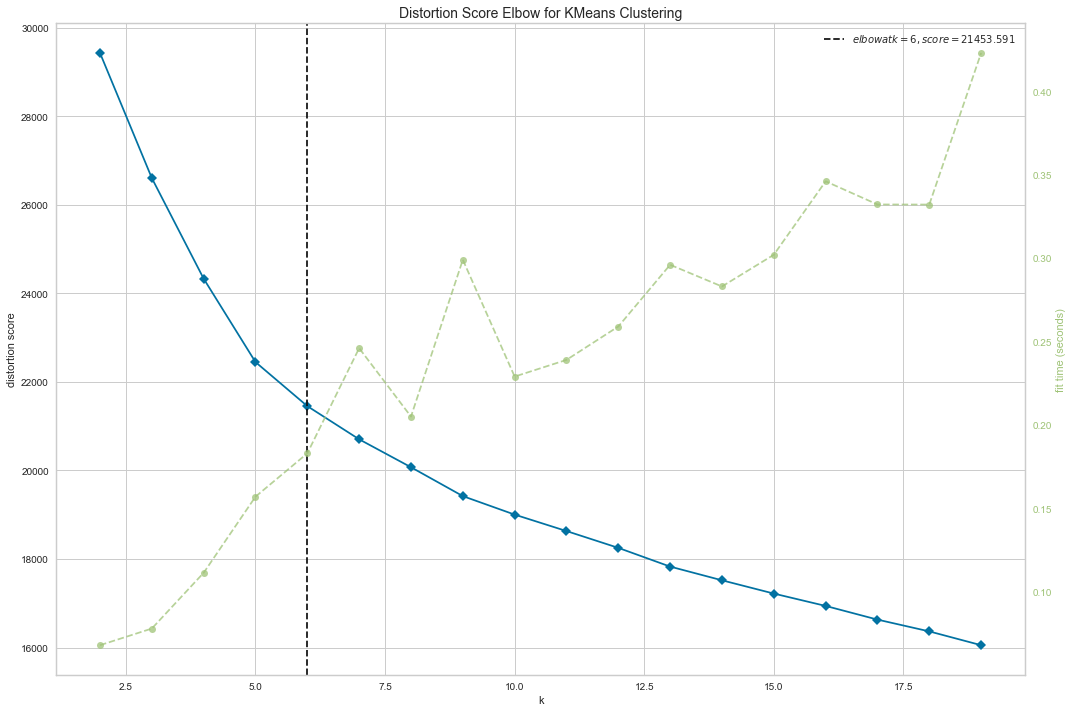

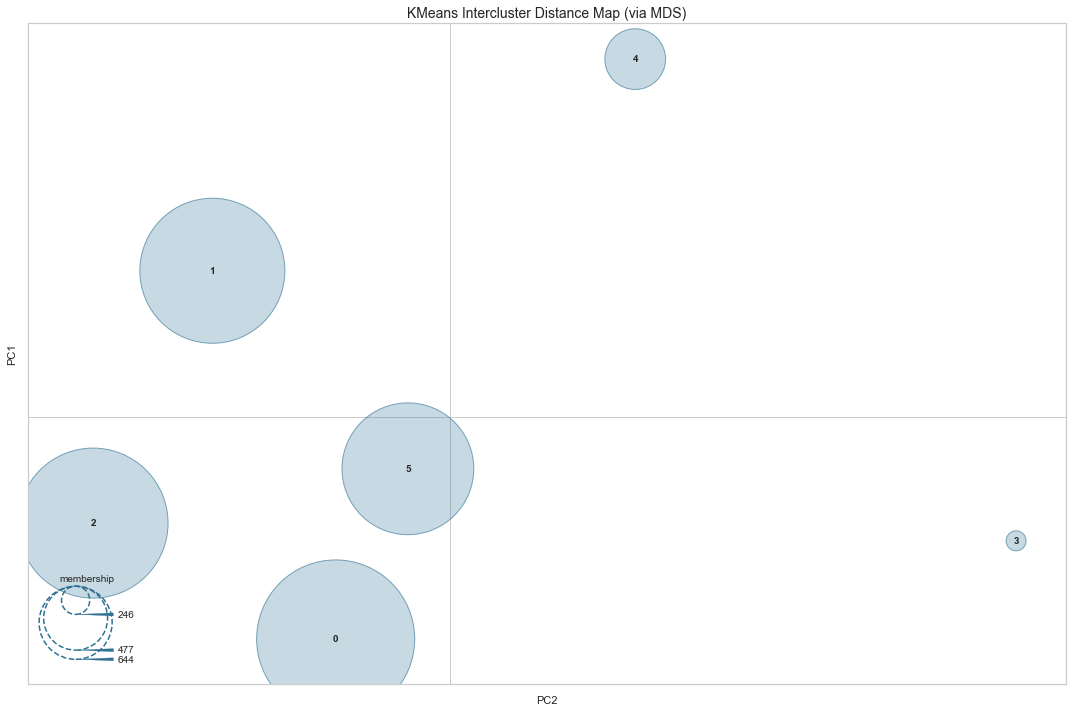

In [227]:
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance
np.random.seed(42)

# Elbow Curve
visualizer = KElbowVisualizer(means, k=(2,20), size=(1080, 720))
visualizer.fit(scaled_df_mm)        # Fit the data to the visualizer
visualizer.show(outpath='./model_pics/cluster/'+'Elbow_Curve.png')        # Finalize and render the figure
plt.show()

# Intra Cluster Distance
visualizer = InterclusterDistance(KMeans(6), size=(1080, 720))
visualizer.fit(scaled_df_mm)        # Fit the data to the visualizer
visualizer.show(outpath='./model_pics/cluster/'+'intra_distance.png')
plt.show()

3    739
1    649
0    592
2    474
4    246
5    237
Name: Cluster, dtype: int64


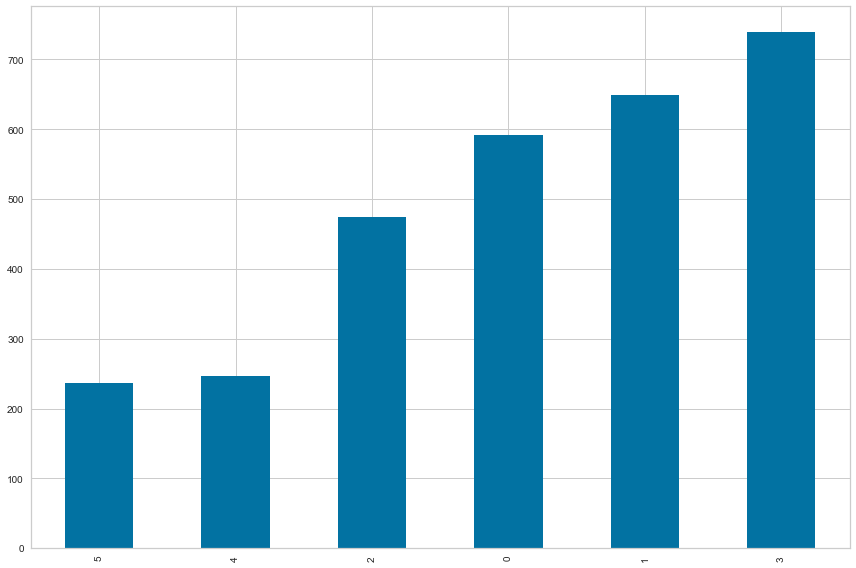

In [228]:
# Following the recommendation above, 6 clusters
means = KMeans(n_clusters=6)
means.fit(scaled_df_mm)
df_household = df_household.assign(Cluster=means.labels_)
print(df_household.Cluster.value_counts())
df_household.Cluster.value_counts(ascending=True).plot(kind='bar')
plt.show()

# Calculate Customer Live Value

* It is a Measurement of customer value
* Can be historical or predicted

* The goal of CLV
    * Measure customer value in revenue / profit 
    * Benchmark customers
    * Identify maximum investment into customer acquisition

# As we do not have the profit margin, we will skip it and do a basic calculation of CLV

CLV = Average Revenue * life Spam

In [229]:
df_transaction = pd.read_csv('capstone_aaa_featured_no_gaps.csv', 
                             parse_dates=['sc_date', 'birth_date_mmddyyyy', 'call_status_recv_date',
                                         'date_of_birth','active_expiration_date', 'cancel_date',
                                         'join_aaa_date', 'join_club_date', 'reinstate_date'
                                         ], 
                             infer_datetime_format=True)
df_transaction.call_status_recv_date = df_transaction.sc_date

In [230]:
df_transaction.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26006 entries, 0 to 26005
Data columns (total 167 columns):
id                                int64
individual_key                    int64
household_key                     int64
member_flag                       int64
city                              object
state_grouped                     object
zip5                              int64
zip9                              int64
fsv_cmsi_flag                     int64
fsv_credit_card_flag              int64
fsv_deposit_program_flag          int64
fsv_home_equity_flag              int64
fsv_id_theft_flag                 int64
fsv_mortgage_flag                 int64
ins_client_flag                   int64
trv_globalware_flag               int64
number_of_children                object
responded_to_catalog              object
race                              object
length_of_residence               int64
mail_responder                    object
home_owner                        object
inc

In [240]:
# AAA Costs
yearly_aaa_costs = df_transaction.groupby(by=['membership_id','csrd_yyyy'])['total_cost'].sum().mean()
yearly_aaa_costs = np.mean(yearly_aaa_costs)

# AAA Revenue
yearly_aaa_rev = df_transaction.groupby(by=['membership_id','csrd_yyyy'])['total_member_cost'].sum().mean()
yearly_aaa_rev = np.mean(yearly_aaa_rev)


# Define Lifespam

lifespam = 36
# Calculate Basic CLV
clv_basic = monthly_aaa_rev * (monthly_aaa_rev-monthly_aaa_costs)/monthly_aaa_costs * lifespam
print('The average basic CLV is {:.1f} USD'.format(clv_basic))

The average basic CLV is 12883.9 USD


76.58239437607344

In [233]:
df_transaction.groupby(by=['membership_id','csrd_yyyymm'])['total_cost'].sum()

membership_id  csrd_yyyymm
153            201501.0000    30.0000
               201509.0000    53.0000
               201604.0000    30.0000
               201607.0000    30.0000
               201611.0000    32.0000
                               ...   
543673         201509.0000    36.0000
               201510.0000    53.0000
               201709.0000    36.0000
               201710.0000    53.0000
543695         201907.0000   117.7000
Name: total_cost, Length: 15997, dtype: float64

In [234]:
cust_month_tx = pd.pivot_table(data=df_transaction, index=['membership_id'],
                               values='total_cost',
                               columns=['sc_date'],
                               aggfunc=np.sum, fill_value=0)
cust_month_tx.head()

sc_date,2014-06-01,2014-06-02,2014-06-03,2014-06-04,2014-06-05,2014-06-06,2014-06-07,2014-06-08,2014-06-09,2014-06-10,2014-06-11,2014-06-12,2014-06-13,2014-06-14,2014-06-15,2014-06-16,2014-06-17,2014-06-18,2014-06-19,2014-06-20,2014-06-21,2014-06-22,2014-06-23,2014-06-24,2014-06-25,2014-06-26,2014-06-27,2014-06-28,2014-06-29,2014-06-30,2014-07-01,2014-07-02,2014-07-03,2014-07-04,2014-07-05,2014-07-06,2014-07-07,2014-07-08,2014-07-09,2014-07-10,2014-07-11,2014-07-12,2014-07-13,2014-07-14,2014-07-15,2014-07-16,2014-07-17,2014-07-18,2014-07-19,2014-07-20,2014-07-21,2014-07-22,2014-07-23,2014-07-24,2014-07-25,2014-07-26,2014-07-27,2014-07-28,2014-07-29,2014-07-30,2014-07-31,2014-08-01,2014-08-02,2014-08-03,2014-08-04,2014-08-05,2014-08-06,2014-08-07,2014-08-08,2014-08-09,2014-08-10,2014-08-11,2014-08-12,2014-08-13,2014-08-14,2014-08-15,2014-08-16,2014-08-17,2014-08-18,2014-08-19,2014-08-20,2014-08-21,2014-08-22,2014-08-23,2014-08-24,2014-08-25,2014-08-26,2014-08-27,2014-08-28,2014-08-29,2014-08-30,2014-08-31,2014-09-01,2014-09-02,2014-09-03,2014-09-04,2014-09-05,2014-09-06,2014-09-07,2014-09-08,2014-09-09,2014-09-10,2014-09-11,2014-09-12,2014-09-13,2014-09-14,2014-09-15,2014-09-16,2014-09-17,2014-09-18,2014-09-19,2014-09-20,2014-09-21,2014-09-22,2014-09-23,2014-09-24,2014-09-25,2014-09-26,2014-09-27,2014-09-28,2014-09-29,2014-09-30,2014-10-01,2014-10-02,2014-10-03,2014-10-04,2014-10-05,2014-10-06,2014-10-07,2014-10-08,2014-10-09,2014-10-10,2014-10-11,2014-10-12,2014-10-13,2014-10-14,2014-10-15,2014-10-16,2014-10-17,2014-10-18,2014-10-19,2014-10-20,2014-10-21,2014-10-22,2014-10-23,2014-10-24,2014-10-25,2014-10-26,2014-10-27,2014-10-28,2014-10-29,2014-10-30,2014-10-31,2014-11-01,2014-11-02,2014-11-03,2014-11-04,2014-11-05,2014-11-06,2014-11-07,2014-11-08,2014-11-09,2014-11-10,2014-11-11,2014-11-12,2014-11-13,2014-11-14,2014-11-15,2014-11-16,2014-11-17,2014-11-18,2014-11-19,2014-11-20,2014-11-21,2014-11-22,2014-11-23,2014-11-24,2014-11-25,2014-11-26,2014-11-27,2014-11-28,2014-11-29,2014-11-30,2014-12-01,2014-12-02,2014-12-03,2014-12-04,2014-12-05,2014-12-06,2014-12-07,2014-12-08,2014-12-09,2014-12-10,2014-12-11,2014-12-12,2014-12-13,2014-12-14,2014-12-15,2014-12-16,2014-12-17,2014-12-18,2014-12-19,2014-12-20,2014-12-21,2014-12-22,2014-12-23,2014-12-24,2014-12-25,2014-12-26,2014-12-27,2014-12-28,2014-12-29,2014-12-30,2014-12-31,2015-01-01,2015-01-02,2015-01-03,2015-01-04,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-10,2015-01-11,2015-01-12,2015-01-13,2015-01-14,2015-01-15,2015-01-16,2015-01-17,2015-01-18,2015-01-19,2015-01-20,2015-01-21,2015-01-22,2015-01-23,2015-01-24,2015-01-25,2015-01-26,2015-01-27,2015-01-28,2015-01-29,2015-01-30,2015-01-31,2015-02-01,2015-02-02,2015-02-03,2015-02-04,2015-02-05,...,2019-02-11,2019-02-12,2019-02-13,2019-02-14,2019-02-15,2019-02-16,2019-02-17,2019-02-18,2019-02-19,2019-02-20,2019-02-21,2019-02-22,2019-02-23,2019-02-24,2019-02-25,2019-02-26,2019-02-27,2019-02-28,2019-03-01,2019-03-02,2019-03-03,2019-03-04,2019-03-05,2019-03-06,2019-03-07,2019-03-08,2019-03-09,2019-03-10,2019-03-11,2019-03-12,2019-03-13,2019-03-14,2019-03-15,2019-03-16,2019-03-17,2019-03-18,2019-03-19,2019-03-20,2019-03-21,2019-03-22,2019-03-23,2019-03-24,2019-03-25,2019-03-26,2019-03-27,2019-03-28,2019-03-29,2019-03-30,2019-03-31,2019-04-01,2019-04-02,2019-04-03,2019-04-04,2019-04-05,2019-04-06,2019-04-07,2019-04-08,2019-04-09,2019-04-10,2019-04-11,2019-04-12,2019-04-13,2019-04-14,2019-04-15,2019-04-16,2019-04-17,2019-04-18,2019-04-19,2019-04-20,2019-04-21,2019-04-22,2019-04-23,2019-04-24,2019-04-25,2019-04-26,2019-04-27,2019-04-28,2019-04-29,2019-04-30,2019-05-01,2019-05-02,2019-05-03,2019-05-04,2019-05-05,2019-05-06,2019-05-07,2019-05-08,2019-05-09,2019-05-10,2019-05-11,2019-05-12,2019-05-13,2019-05-14,2019-05-15,2019-05-16,2019-05-17,2019-05-18,2019-05-19,2019-05-20,2019-05-21,2019-05-22,2019-05-23,2019-05-24,2019-05-25,2019-05-26,2019-05-27,2019-05-28,2019-05-29,2019-05-30,2019-05-31,2019-06-01,2019-06-02,2019-0